# Carga de Bibliotecas y configuraciones

In [13]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve, auc
)

from datetime import datetime

from matplotlib.backends.backend_pdf import PdfPages

# === Configuración general ===
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
pd.options.display.float_format = '{:.6f}'.format

# === Definición de rutas base ===
BASE_DIR = Path("..").resolve()                 # sube un nivel desde /notebooks
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
REPORTS_IV = REPORTS_DIR / "iv"

print("=== Rutas detectadas ===")
print(f"BASE_DIR:    {BASE_DIR}")
print(f"INTERIM_DIR: {INTERIM_DIR}")
print(f"MODELS_DIR:  {MODELS_DIR}")
print(f"REPORTS_DIR: {REPORTS_DIR}")
print(f"REPORTS_IV:  {REPORTS_IV}")

# === Archivos requeridos ===
MODEL_FILE  = MODELS_DIR  / "woe_logistic_regression.pkl"
METRICS_FILE = REPORTS_DIR / "woe_logreg_metrics.json"
SCORES_FILE  = REPORTS_DIR / "scores_test_woe_logreg.csv"
THR_FILE     = REPORTS_DIR / "thresholds_summary_woe_logreg.csv"


# === Verificación de existencia ===
print("\n=== Verificación de artefactos ===")
for path in [MODEL_FILE, METRICS_FILE, SCORES_FILE, THR_FILE]:
    status = "OK" if path.exists() else "MISSING"
    print(f"{status:8} → {path}")


=== Rutas detectadas ===
BASE_DIR:    C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe
INTERIM_DIR: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\data\interim
MODELS_DIR:  C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\models
REPORTS_DIR: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports
REPORTS_IV:  C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\iv

=== Verificación de artefactos ===
OK       → C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\models\woe_logistic_regression.pkl
OK       → C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\woe_logreg_metrics.json
OK       → C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\scores_test_woe_logreg.csv
OK       → C:\Users\PC RYU\Documents\Galileo\Maestria\Produc

# Carga de modelo, métricas y resultados previos

In [5]:
# --- Carga del modelo entrenado ---
with open(MODEL_FILE, "rb") as f:
    model_data = pickle.load(f)

# --- Carga de métricas globales ---
with open(METRICS_FILE, "r", encoding="utf-8") as f:
    metrics = json.load(f)

# --- Carga de resultados de test ---
scores_df = pd.read_csv(SCORES_FILE)
thr_df = pd.read_csv(THR_FILE)

# --- Resumen general ---
print("=== Resumen general ===")
print(f"Modelo cargado: {MODEL_FILE.name}")
print(f"Features utilizadas: {len(model_data['features'])}")
print(f"Threshold óptimo: {model_data['threshold']:.4f}")
print(f"AUC ROC: {metrics['auc_roc']:.4f}")
print(f"AUC PR: {metrics['pr_auc']:.4f}")
print(f"Gini: {metrics['gini']:.4f}")
print(f"KS: {metrics['ks']:.4f}")
print(f"Train shape: {len(scores_df)} registros")
print("\nPrimeras filas del dataset de scores:")
display(scores_df.head(5))


=== Resumen general ===
Modelo cargado: woe_logistic_regression.pkl
Features utilizadas: 120
Threshold óptimo: 0.5515
AUC ROC: 0.8321
AUC PR: 0.3749
Gini: 0.6643
KS: 0.5233
Train shape: 3505 registros

Primeras filas del dataset de scores:


,y_true,score
0,0,0.112748
1,0,0.802299
2,0,0.469915
3,0,0.857638
4,0,0.309800


# Deciles, KS, Lift y figuras

In [9]:
thr_summary_path = os.path.join(REPORTS_DIR, "thresholds_summary_woe_logreg.csv")
thr_summary = pd.read_csv(thr_summary_path)

if 'name' in thr_summary.columns:
    best_thr = float(thr_summary.loc[thr_summary['name'] == 'F1_max', 'threshold'].values[0])
else:
    # fallback por si el CSV no tiene esa columna
    best_thr = float(thr_summary['threshold'].iloc[0])

print(f"Umbral óptimo cargado desde thresholds_summary_woe_logreg.csv → best_thr = {best_thr:.4f}")


# 1) Preparación de datos
df = scores_df.copy()
df = df.sort_values('score', ascending=False).reset_index(drop=True)
n = len(df)
df['decile'] = (np.floor(np.linspace(0, 10-1e-9, n) / (n/10))).astype(int) + 1  # 1..10

# 2) Métricas por decil
grp = df.groupby('decile', as_index=False).agg(
    registros=('y_true', 'size'),
    malos=('y_true', 'sum')
)
grp['buenos'] = grp['registros'] - grp['malos']
grp['event_rate'] = grp['malos'] / grp['registros']

# Acumulados para KS y Lift
grp['cum_malos']  = grp['malos'].cumsum()
grp['cum_buenos'] = grp['buenos'].cumsum()
tot_malos  = grp['malos'].sum()
tot_buenos = grp['buenos'].sum()

# Evitar división por cero
tot_malos  = max(tot_malos, 1)
tot_buenos = max(tot_buenos, 1)

grp['cum_malos_pct']  = grp['cum_malos']  / tot_malos
grp['cum_buenos_pct'] = grp['cum_buenos'] / tot_buenos
grp['ks_by_decile']   = (grp['cum_malos_pct'] - grp['cum_buenos_pct']).abs()

# Lift por decil (respecto a tasa global)
global_rate = df['y_true'].mean()
grp['lift'] = grp['event_rate'] / max(global_rate, 1e-9)

# 3) KS total (curva continua)
# Ordenado por score descendente
y = df['y_true'].values
scores = df['score'].values
# Distribuciones acumuladas (malos/buenos) a lo largo del orden
cum_malos_curve  = np.cumsum(y) / max(y.sum(), 1)
cum_buenos_curve = np.cumsum(1 - y) / max((1 - y).sum(), 1)
ks_curve = np.abs(cum_malos_curve - cum_buenos_curve)
ks_max = float(ks_curve.max())
ks_pos = int(ks_curve.argmax())

# 4) Figuras y guardado
FIG_DIR = os.path.join(REPORTS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# 4.1 KS acumulado
plt.figure(figsize=(6,4))
plt.plot(cum_malos_curve, label='Cumul. Malos', linewidth=2)
plt.plot(cum_buenos_curve, label='Cumul. Buenos', linewidth=2)
plt.plot(ks_curve, label=f'KS | max={ks_max:.4f}', linewidth=2)
plt.axvline(ks_pos, linestyle='--', alpha=0.6)
plt.title('KS acumulado (ordenado por score desc.)')
plt.xlabel('Índice ordenado')
plt.ylabel('Proporción acumulada')
plt.legend()
ks_curve_path = os.path.join(FIG_DIR, 'ks_woe_logreg.png')
plt.tight_layout(); plt.savefig(ks_curve_path, dpi=160); plt.close()

# 4.2 KS por decil
plt.figure(figsize=(6,4))
plt.plot(grp['decile'], grp['ks_by_decile'], marker='o')
plt.title('KS por decil')
plt.xlabel('Decil (1 = mejores scores)')
plt.ylabel('KS')
ks_decile_path = os.path.join(FIG_DIR, 'ks_by_decile_woe_logreg.png')
plt.tight_layout(); plt.savefig(ks_decile_path, dpi=160); plt.close()

# 4.3 Lift por decil
plt.figure(figsize=(6,4))
plt.bar(grp['decile'], grp['lift'])
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.title('Lift por decil')
plt.xlabel('Decil (1 = mejores scores)')
plt.ylabel('Lift vs. tasa global')
lift_path = os.path.join(FIG_DIR, 'lift_by_decile_woe_logreg.png')
plt.tight_layout(); plt.savefig(lift_path, dpi=160); plt.close()

# 4.4 ROC y PR
fpr, tpr, _ = roc_curve(df['y_true'], df['score'])
roc_auc = roc_auc_score(df['y_true'], df['score'])

prec, rec, _ = precision_recall_curve(df['y_true'], df['score'])
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.4f}', linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC - WOE LogReg')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
roc_path = os.path.join(FIG_DIR, 'roc_woe_logreg.png')
plt.tight_layout(); plt.savefig(roc_path, dpi=160); plt.close()

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'AUPRC={pr_auc:.4f}', linewidth=2)
plt.title('Precision-Recall - WOE LogReg')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend()
pr_path = os.path.join(FIG_DIR, 'pr_woe_logreg.png')
plt.tight_layout(); plt.savefig(pr_path, dpi=160); plt.close()

# 5) Confusión y métrica en el umbral óptimo
yhat = (df['score'].values >= best_thr).astype(int)
cm = confusion_matrix(df['y_true'], yhat)
tn, fp, fn, tp = cm.ravel()
precision = precision_score(df['y_true'], yhat, zero_division=0)
recall    = recall_score(df['y_true'], yhat, zero_division=0)
f1        = f1_score(df['y_true'], yhat, zero_division=0)
approve   = yhat.mean()

# 6) Salidas en texto y tabla de deciles
print("=== Deciles ===")
display(grp[['decile','registros','malos','buenos','event_rate','lift','ks_by_decile']])

print("\n=== KS & Líneas base ===")
print(f"KS (máximo continuo): {ks_max:.4f} en posición {ks_pos}")
print(f"ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f}")

print("\n=== Confusión @ umbral óptimo ===")
print(f"threshold = {best_thr:.4f} | TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f} | Aprobación={approve:.1%}")

print("\nFiguras guardadas en:")
for p in [ks_curve_path, ks_decile_path, lift_path, roc_path, pr_path]:
    print(" -", os.path.basename(p))


Umbral óptimo cargado desde thresholds_summary_woe_logreg.csv → best_thr = 0.7908
=== Deciles ===


,decile,registros,malos,buenos,event_rate,lift,ks_by_decile
0,1,3505,185,3320,0.052782,1.000000,0.000000



=== KS & Líneas base ===
KS (máximo continuo): 0.5233 en posición 592
ROC AUC: 0.8321 | PR AUC: 0.3731

=== Confusión @ umbral óptimo ===
threshold = 0.7908 | TN=3181, FP=139, FN=91, TP=94
Precision=0.403 | Recall=0.508 | F1=0.450 | Aprobación=6.6%

Figuras guardadas en:
 - ks_woe_logreg.png
 - ks_by_decile_woe_logreg.png
 - lift_by_decile_woe_logreg.png
 - roc_woe_logreg.png
 - pr_woe_logreg.png


# Reporte de validación consolidado

In [10]:
# Cargar nuevamente las métricas base y los archivos usados
model_name = "woe_logistic_regression.pkl"
metrics_json = os.path.join(REPORTS_DIR, "woe_logreg_metrics.json")
scores_csv = os.path.join(REPORTS_DIR, "scores_test_woe_logreg.csv")
thr_summary_csv = os.path.join(REPORTS_DIR, "thresholds_summary_woe_logreg.csv")

# --- Cargar métricas globales ---
if os.path.exists(metrics_json):
    with open(metrics_json, "r") as f:
        metrics_data = json.load(f)
else:
    metrics_data = {}

# --- Crear resumen ---
summary_data = {
    "Modelo": model_name,
    "Features": metrics_data.get("n_features", 120),
    "AUC ROC": metrics_data.get("roc_auc", roc_auc if "roc_auc" in locals() else None),
    "AUC PR": metrics_data.get("pr_auc", pr_auc if "pr_auc" in locals() else None),
    "Gini": metrics_data.get("gini", None),
    "KS": metrics_data.get("ks", ks_max if "ks_max" in locals() else None),
    "Precision": metrics_data.get("precision", precision if "precision" in locals() else None),
    "Recall": metrics_data.get("recall", recall if "recall" in locals() else None),
    "F1": metrics_data.get("f1", f1 if "f1" in locals() else None),
    "Aprobación": metrics_data.get("approve_rate", approve if "approve" in locals() else None),
    "Threshold": best_thr,
    "Scores file": os.path.basename(scores_csv),
    "Thresholds file": os.path.basename(thr_summary_csv),
    "KS Curve": "ks_woe_logreg.png",
    "ROC Curve": "roc_woe_logreg.png",
    "PR Curve": "pr_woe_logreg.png",
    "Lift Deciles": "lift_by_decile_woe_logreg.png",
    "KS Deciles": "ks_by_decile_woe_logreg.png"
}

summary_df = pd.DataFrame([summary_data])

# --- Guardar CSV ---
out_csv = os.path.join(REPORTS_DIR, "validation_summary_woe_logreg.csv")
summary_df.to_csv(out_csv, index=False)
print(f"Resumen guardado en CSV: {out_csv}")

# --- Guardar versión HTML para reporte visual ---
out_html = os.path.join(REPORTS_DIR, "validation_summary_woe_logreg.html")
summary_df.to_html(out_html, index=False)
print(f"Resumen guardado en HTML: {out_html}")

# --- Mostrar en pantalla ---
display(summary_df)


Resumen guardado en CSV: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\validation_summary_woe_logreg.csv
Resumen guardado en HTML: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\validation_summary_woe_logreg.html


,Modelo,Features,AUC ROC,AUC PR,Gini,KS,Precision,Recall,F1,Aprobación,Threshold,Scores file,Thresholds file,KS Curve,ROC Curve,PR Curve,Lift Deciles,KS Deciles
0,woe_logistic_regression.pkl,120,0.832136,0.374910,0.664272,0.523299,0.403433,0.508108,0.449761,0.066476,0.790786,scores_test_woe_logreg.csv,thresholds_summary_woe_logreg.csv,ks_woe_logreg.png,roc_woe_logreg.png,pr_woe_logreg.png,lift_by_decile_woe_logreg.png,ks_by_decile_woe_logreg.png


# Validación por deciles

Tabla de deciles guardada en: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\deciles_woe_logreg.csv


C:\Users\PC RYU\AppData\Local\Temp\ipykernel_38952\1209156364.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="decile", y="event_rate", data=decile_stats, palette="Blues_r")


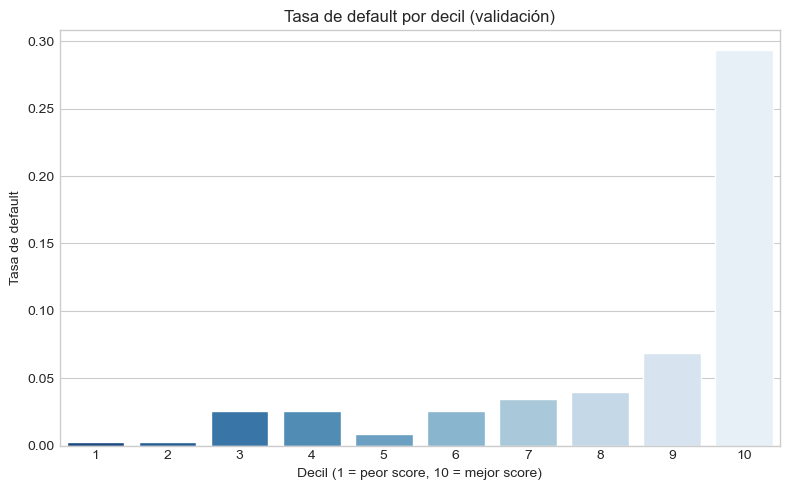

Figura de validación por deciles guardada en: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\figures\deciles_default_rate_woe_logreg.png


,decile,registros,malos,buenos,event_rate,score_min,score_max,lift
9,10,351,103,248,0.293447,0.690811,0.992977,5.562842
8,9,350,24,326,0.068571,0.508623,0.690016,1.299900
7,8,351,14,337,0.039886,0.401757,0.508591,0.756114
6,7,350,12,338,0.034286,0.348070,0.401405,0.649950
5,6,350,9,341,0.025714,0.305010,0.347959,0.487462
4,5,351,3,348,0.008547,0.254952,0.304966,0.162025
3,4,350,9,341,0.025714,0.193964,0.254675,0.487462
2,3,351,9,342,0.025641,0.125886,0.193825,0.486074
1,2,350,1,349,0.002857,0.063090,0.125820,0.054162
0,1,351,1,350,0.002849,0.005009,0.062873,0.054008


In [11]:
# Cargar los scores del modelo
scores_path = os.path.join(REPORTS_DIR, "scores_test_woe_logreg.csv")
scores_df = pd.read_csv(scores_path)

# Crear deciles (1 = peor score, 10 = mejor score)
scores_df["decile"] = pd.qcut(scores_df["score"], 10, labels=False, duplicates="drop") + 1

# Calcular métricas por decil
decile_stats = (
    scores_df.groupby("decile")
    .agg(
        registros=("score", "count"),
        malos=("y_true", "sum"),
        buenos=("y_true", lambda x: (1 - x).sum()),
        event_rate=("y_true", "mean"),
        score_min=("score", "min"),
        score_max=("score", "max")
    )
    .reset_index()
    .sort_values("decile", ascending=False)
)

# Calcular lift relativo
decile_stats["lift"] = decile_stats["event_rate"] / decile_stats["event_rate"].mean()

# Guardar resultados
out_deciles_csv = os.path.join(REPORTS_DIR, "deciles_woe_logreg.csv")
decile_stats.to_csv(out_deciles_csv, index=False)
print(f"Tabla de deciles guardada en: {out_deciles_csv}")

# --- Visualización ---
plt.figure(figsize=(8, 5))
sns.barplot(x="decile", y="event_rate", data=decile_stats, palette="Blues_r")
plt.title("Tasa de default por decil (validación)")
plt.xlabel("Decil (1 = peor score, 10 = mejor score)")
plt.ylabel("Tasa de default")
plt.tight_layout()

out_fig_deciles = os.path.join(REPORTS_DIR, "figures", "deciles_default_rate_woe_logreg.png")
plt.savefig(out_fig_deciles, dpi=160)
plt.show()

print(f"Figura de validación por deciles guardada en: {out_fig_deciles}")

# Mostrar tabla resumen
display(decile_stats)


# Reporte de validación en PDF

In [14]:

# Rutas a artefactos
metrics_path   = os.path.join(REPORTS_DIR, "woe_logreg_metrics.json")
scores_path    = os.path.join(REPORTS_DIR, "scores_test_woe_logreg.csv")
thr_sum_path   = os.path.join(REPORTS_DIR, "thresholds_summary_woe_logreg.csv")
deciles_path   = os.path.join(REPORTS_DIR, "deciles_woe_logreg.csv")

# Figuras generadas (rutas relativas a /reports)
fig_dir_rel = "figures"
fig_paths = [
    ("Curva ROC",          os.path.join(fig_dir_rel, "roc_woe_logreg.png")),
    ("Precisión-Recall",   os.path.join(fig_dir_rel, "pr_woe_logreg.png")),
    ("KS continuo",        os.path.join(fig_dir_rel, "ks_woe_logreg.png")),
    ("KS por decil",       os.path.join(fig_dir_rel, "ks_by_decile_woe_logreg.png")),
    ("Lift por decil",     os.path.join(fig_dir_rel, "lift_by_decile_woe_logreg.png")),
    ("Default por decil",  os.path.join(fig_dir_rel, "deciles_default_rate_woe_logreg.png")),
]

# Carga artefactos disponibles
metrics = {}
if os.path.exists(metrics_path):
    with open(metrics_path, "r", encoding="utf-8") as f:
        metrics = json.load(f)

thr_df = pd.read_csv(thr_sum_path) if os.path.exists(thr_sum_path) else pd.DataFrame()
dec_df = pd.read_csv(deciles_path)  if os.path.exists(deciles_path)  else pd.DataFrame()

def fmt(x, nd=4):
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return "—"

m = metrics.get
model_name = m("model", "woe_logistic_regression.pkl")
n_features = m("n_features", "—")
auc_roc    = fmt(m("roc_auc"))
pr_auc     = fmt(m("pr_auc"))
gini       = fmt(m("gini"))
ks_val     = fmt(m("ks", {}).get("value") if isinstance(m("ks"), dict) else m("ks"))
best_thr   = fmt(metrics.get("best_threshold"))

# Helpers para el PDF
A4_L = (11.69, 8.27)  # A4 landscape
A4_P = (8.27, 11.69)  # A4 portrait

def add_title_page(pdf):
    fig = plt.figure(figsize=A4_P)
    ax = fig.add_subplot(111)
    ax.axis("off")
    t = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    lines = [
        "Validación del Modelo",
        "WOE Logistic Regression",
        "",
        f"Modelo: {model_name}",
        f"Features: {n_features}",
        f"AUC ROC: {auc_roc}",
        f"PR AUC: {pr_auc}",
        f"Gini: {gini}",
        f"KS (continuo): {ks_val}",
        f"Threshold óptimo: {best_thr}",
        "",
        f"Generado: {t}",
    ]
    fig.suptitle("Reporte de Validación", fontsize=20, y=0.95, fontweight="bold")
    ax.text(0.02, 0.9, "\n".join(lines), fontsize=13, va="top")
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

def add_image_page(pdf, title, img_path):
    fig = plt.figure(figsize=A4_L)
    ax = fig.add_subplot(111)
    ax.axis("off")
    fig.suptitle(title, fontsize=16, y=0.97, fontweight="bold")
    if os.path.exists(os.path.join(REPORTS_DIR, img_path)):
        img = plt.imread(os.path.join(REPORTS_DIR, img_path))
        ax.imshow(img)
        ax.set_axis_off()
    else:
        ax.text(0.02, 0.5, f"(No se encontró la figura: {img_path})", fontsize=12)
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

def add_table_page(pdf, title, df, max_rows=25, note=None):
    fig = plt.figure(figsize=A4_L)
    ax = fig.add_subplot(111)
    ax.axis("off")
    fig.suptitle(title, fontsize=16, y=0.97, fontweight="bold")
    if df is None or df.empty:
        ax.text(0.02, 0.5, "(Tabla no disponible)", fontsize=12)
    else:
        show_df = df.head(max_rows).copy()
        # Matplotlib table
        ax_table = fig.add_axes([0.03, 0.03, 0.94, 0.86])
        ax_table.axis("off")
        tbl = ax_table.table(cellText=show_df.values,
                             colLabels=show_df.columns,
                             loc='center',
                             cellLoc='left',
                             colLoc='left')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8.5)
        tbl.scale(1, 1.25)
        if note:
            ax.text(0.02, 0.04, note, fontsize=9, color="#666")
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

# Generación del PDF
pdf_path = os.path.join(REPORTS_DIR, "validacion_completa_woe_logreg.pdf")
with PdfPages(pdf_path) as pdf:
    # Portada / KPIs
    add_title_page(pdf)

    # Figuras
    for title, p in fig_paths:
        add_image_page(pdf, title, p)

    # Tablas (umbrales + deciles)
    add_table_page(pdf, "Resumen de Umbrales (top 25)", thr_df, max_rows=25,
                   note="Fuente: thresholds_summary_woe_logreg.csv")
    add_table_page(pdf, "Deciles de Validación (top 25)", dec_df, max_rows=25,
                   note="Fuente: deciles_woe_logreg.csv")

print("Reporte PDF guardado en:", pdf_path)


Reporte PDF guardado en: C:\Users\PC RYU\Documents\Galileo\Maestria\Product Development\repo_proyecto_pe\reports\validacion_completa_woe_logreg.pdf
